In [1]:
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Data loading, feature engineering

In [2]:
raw_data = pd.read_csv("https://osf.io/download/3qyut/")

In [3]:
raw_data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287829 entries, 0 to 287828
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comp_id               287829 non-null  float64
 1   begin                 287829 non-null  object 
 2   end                   287829 non-null  object 
 3   COGS                  18257 non-null   float64
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  finished_prod         17485 non-null   float64
 11  fixed_assets          287698 non-null  float64
 12  inc_bef_tax           280392 non-null  float64
 13  intang_assets         287689 non-null  float64
 14  inventories           287698 non-null  float64
 15  

In [5]:
# dropping columns with many missing variables (COGS, finished_prod, net_dom_sales, net_exp_sales, wages, D, exit_year, exit_data)

raw_data = raw_data.drop(columns = ['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', 'D', 'exit_year', 'exit_date'])

In [6]:
# adding age of firms

raw_data["age"] = np.where(
    raw_data["year"] - raw_data["founded_year"] < 0, 0, raw_data["year"] - raw_data["founded_year"])

In [7]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
raw_data = (
    raw_data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
raw_data = raw_data.replace("toReplace", np.nan)

In [8]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
raw_data["status_alive"] = (raw_data["sales"] > 0 & (False == raw_data["sales"].isna())).astype(int)

In [9]:
# defaults in 1 year if there are sales in this year but no sales one year later

raw_data["default"] = (
    (raw_data["status_alive"] == 1)
    & (raw_data.groupby("comp_id")["status_alive"].shift(-1) == 0)
).astype(int)

In [10]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556944 entries, 0 to 556943
Data columns (total 43 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  556944 non-null  int64  
 1   comp_id               556944 non-null  float64
 2   begin                 287829 non-null  object 
 3   end                   287829 non-null  object 
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  fixed_assets          287698 non-null  float64
 11  inc_bef_tax           280392 non-null  float64
 12  intang_assets         287689 non-null  float64
 13  inventories           287698 non-null  float64
 14  liq_assets            287698 non-null  float64
 15  

In [11]:
# assets can't be negative. Change them to 0 and add a flag.
raw_data["flag_asset_problem"] = np.where(
    (
        (raw_data["intang_assets"] < 0)
        | (raw_data["curr_assets"] < 0)
        | (raw_data["fixed_assets"] < 0)
    ),
    1,
    0,
)
raw_data["flag_asset_problem"] = np.where(
    (
        (raw_data["intang_assets"].isna())
        | (raw_data["curr_assets"].isna())
        | (raw_data["fixed_assets"].isna())
    ),
    np.nan,
    raw_data["flag_asset_problem"],
)
raw_data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    287466
1.0       223
Name: comp_id, dtype: int64

In [12]:
# impute with 0 for asset problems

raw_data["intang_assets"] = np.where(raw_data["intang_assets"] < 0, 0, raw_data["intang_assets"])
raw_data["curr_assets"] = np.where(raw_data["curr_assets"] < 0, 0, raw_data["curr_assets"])
raw_data["fixed_assets"] = np.where(raw_data["fixed_assets"] < 0, 0, raw_data["fixed_assets"])

In [13]:
# generate total assets
raw_data["total_assets_bs"] = (
    raw_data["intang_assets"] + raw_data["curr_assets"] + raw_data["fixed_assets"]
)
round(raw_data["total_assets_bs"].describe(), 3)

count    2.876890e+05
mean     5.980575e+05
std      2.623770e+07
min      0.000000e+00
25%      4.792593e+03
50%      2.024815e+04
75%      8.810740e+04
max      1.032471e+10
Name: total_assets_bs, dtype: float64

In [14]:
# define P&L and Balance sheet column names

pl_names = ['extra_exp','extra_inc',  'extra_profit_loss', 'inc_bef_tax' ,'inventories',
              'material_exp', 'profit_loss_year', 'personnel_exp']
bs_names = ['intang_assets', 'curr_liab', 'fixed_assets', 'liq_assets', 'curr_assets',
              'share_eq', 'subscribed_cap', 'tang_assets' ]

In [15]:
# divide all pl_names elements by sales and create new column for it
raw_data[[col + "_pl" for col in pl_names]] = raw_data[pl_names].div(
    raw_data["sales"], axis="index"
)

In [16]:
# divide all bs_names elements by total_assets_bs and create new column for it
raw_data[[col + "_bs" for col in bs_names]] = (
    raw_data[bs_names]
    .div(raw_data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)

In [17]:
# imputing labor_avg and birth_year, adding flag and dropping original column - these have the highest number of missing values. 

raw_data["labor_avg_mod"] = np.where(
    raw_data["labor_avg"].isna(), raw_data["labor_avg"].mean(), raw_data["labor_avg"]
)
raw_data["flag_miss_labor_avg"] = (raw_data["labor_avg"].isna()).astype(int)
raw_data = raw_data.drop(['labor_avg'], axis=1)

raw_data["birth_year_mod"] = np.where(
    raw_data["birth_year"].isna(), raw_data["birth_year"].mean(), raw_data["birth_year"]
)
raw_data["flag_miss_birth_year"] = (raw_data["birth_year"].isna()).astype(int)
raw_data = raw_data.drop(['birth_year'], axis=1)

In [18]:
# convert to categorical where relevant

cat_vars = ["gender", "origin", "ind2", "ind", "urban_m", "region_m", "nace_main"]

for col in cat_vars:
    raw_data[col] = raw_data[col].astype("category")

In [19]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556944 entries, 0 to 556943
Data columns (total 63 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   year                  556944 non-null  int64   
 1   comp_id               556944 non-null  float64 
 2   begin                 287829 non-null  object  
 3   end                   287829 non-null  object  
 4   amort                 279789 non-null  float64 
 5   curr_assets           287698 non-null  float64 
 6   curr_liab             287698 non-null  float64 
 7   extra_exp             269300 non-null  float64 
 8   extra_inc             269300 non-null  float64 
 9   extra_profit_loss     270626 non-null  float64 
 10  fixed_assets          287698 non-null  float64 
 11  inc_bef_tax           280392 non-null  float64 
 12  intang_assets         287689 non-null  float64 
 13  inventories           287698 non-null  float64 
 14  liq_assets            287698 non-nul

In [20]:
holdout_data = raw_data[raw_data["ind2"] == 26]
holdout_data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,fixed_assets_bs,liq_assets_bs,curr_assets_bs,share_eq_bs,subscribed_cap_bs,tang_assets_bs,labor_avg_mod,flag_miss_labor_avg,birth_year_mod,flag_miss_birth_year
156,2005,6.538183e+06,2005-01-01,2005-12-31,792.592590,6237.037109,348.148163,0.000000,0.000000,0.000000,...,0.214552,0.689366,0.785448,0.946828,0.006996,0.214552,1.009435,1,1964.902661,1
162,2005,6.934257e+06,2005-05-13,2005-12-31,803.703674,4648.147949,9311.111328,0.000000,0.000000,0.000000,...,0.718736,0.147692,0.281264,0.034738,0.672344,0.718736,1.009435,1,1964.902661,1
182,2005,8.416055e+06,2005-01-01,2005-12-31,3155.555664,71070.367188,25514.814453,74.074074,0.000000,-74.074074,...,0.151399,0.747625,0.847983,0.701843,0.132573,0.150780,1.009435,1,1960.000000,0
234,2005,1.242838e+07,2005-01-01,2005-12-31,3137.037109,1740.740723,2192.592529,0.000000,0.000000,0.000000,...,0.521212,0.450505,0.474747,0.397980,0.020202,0.517172,1.009435,1,1964.902661,1
261,2005,1.571155e+07,2005-01-01,2005-12-31,1592.592651,4740.740723,4970.370605,0.000000,7407.407227,7407.407227,...,0.171521,0.274434,0.828479,0.131392,1.941748,0.171521,1.009435,1,1964.902661,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556634,2016,4.580800e+11,2016-01-01,2016-12-31,3529.629639,125537.039062,0.000000,NaN,NaN,NaN,...,0.102048,0.316502,0.897952,0.920656,0.079477,0.102048,0.166667,0,1959.000000,0
556683,2016,4.591262e+11,2016-01-01,2016-12-31,4011.111084,58948.148438,30874.074219,NaN,NaN,NaN,...,0.232816,0.367011,0.767184,0.630146,1.332787,0.232816,0.125000,0,1964.902661,1
556789,2016,4.610112e+11,2016-01-01,2016-12-31,148.148148,67448.148438,5059.259277,NaN,NaN,NaN,...,0.042802,0.441048,0.956410,0.929626,0.157555,0.042015,0.250000,0,1959.000000,0
556842,2016,4.620594e+11,2016-01-01,2016-12-31,559.259277,64011.109375,8662.962891,NaN,NaN,NaN,...,0.000000,0.037841,1.000000,0.866111,0.173581,0.000000,0.118056,0,1953.000000,0


In [21]:
# look at cross section
holdout_data = holdout_data.query("year==2014 & status_alive == 1")
# look at firms below 10m euro revenues and above 1000 euros
holdout_data = holdout_data.query("sales<=10000000 & sales>=1000")
holdout_data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,fixed_assets_bs,liq_assets_bs,curr_assets_bs,share_eq_bs,subscribed_cap_bs,tang_assets_bs,labor_avg_mod,flag_miss_labor_avg,birth_year_mod,flag_miss_birth_year
417864,2014,6.538183e+06,2014-01-01,2014-12-31,1018.518494,17022.222656,3040.740723,0.0,0.0,0.0,...,0.164819,0.832455,0.835181,0.850809,0.002726,0.164819,1.009435,1,1961.5,0
417890,2014,8.416055e+06,2014-01-01,2014-12-31,425.925934,105740.742188,6918.518555,0.0,0.0,0.0,...,0.067207,0.680041,0.932793,0.945372,0.098017,0.067207,0.083333,0,1960.0,0
417942,2014,1.242838e+07,2014-01-01,2014-12-31,0.000000,0.000000,9277.777344,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0,1962.0,0
417989,2014,1.777654e+07,2014-01-01,2014-12-31,48.148148,142296.296875,164237.031250,0.0,0.0,0.0,...,0.510834,0.007804,0.403525,0.406907,0.136539,0.425192,0.305556,0,1970.5,0
417994,2014,1.862676e+07,2014-01-01,2014-12-31,5755.555664,95185.187500,45766.667969,0.0,0.0,0.0,...,0.193371,0.094661,0.806629,0.611594,0.015693,0.193371,0.159091,0,1978.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463875,2014,4.593723e+11,2014-01-01,2014-12-31,0.000000,40740.742188,559.259277,0.0,0.0,0.0,...,0.000000,0.943727,1.000000,0.986273,0.023000,0.000000,0.083333,0,1975.0,0
463965,2014,4.610112e+11,2014-01-01,2014-12-31,429.629639,58781.480469,2651.851807,0.0,0.0,0.0,...,0.055866,0.637822,0.943243,0.957387,0.178296,0.054974,0.166667,0,1959.0,0
464018,2014,4.620594e+11,2014-01-01,2014-12-31,1111.111084,68274.070312,16211.111328,0.0,0.0,0.0,...,0.011635,0.024288,0.988365,0.765321,0.160849,0.011635,0.250000,0,1953.0,0
464032,2014,4.623300e+11,2014-01-01,2014-12-31,0.000000,17192.591797,7325.925781,0.0,0.0,0.0,...,0.375656,0.368796,0.624344,0.654472,0.672495,0.375656,0.166667,0,1961.5,0


In [22]:
round(holdout_data.sales.describe(), 3)

count       1037.000
mean      490202.218
std      1154087.414
min         1070.370
25%        21766.666
50%        72700.000
75%       333888.875
max      9576485.000
Name: sales, dtype: float64

In [23]:
holdout_data.default.value_counts()

default
0    981
1     56
Name: count, dtype: int64

The holdout_data now contains the right dataset (1037 observations, 56 defaults, correct sales figures).

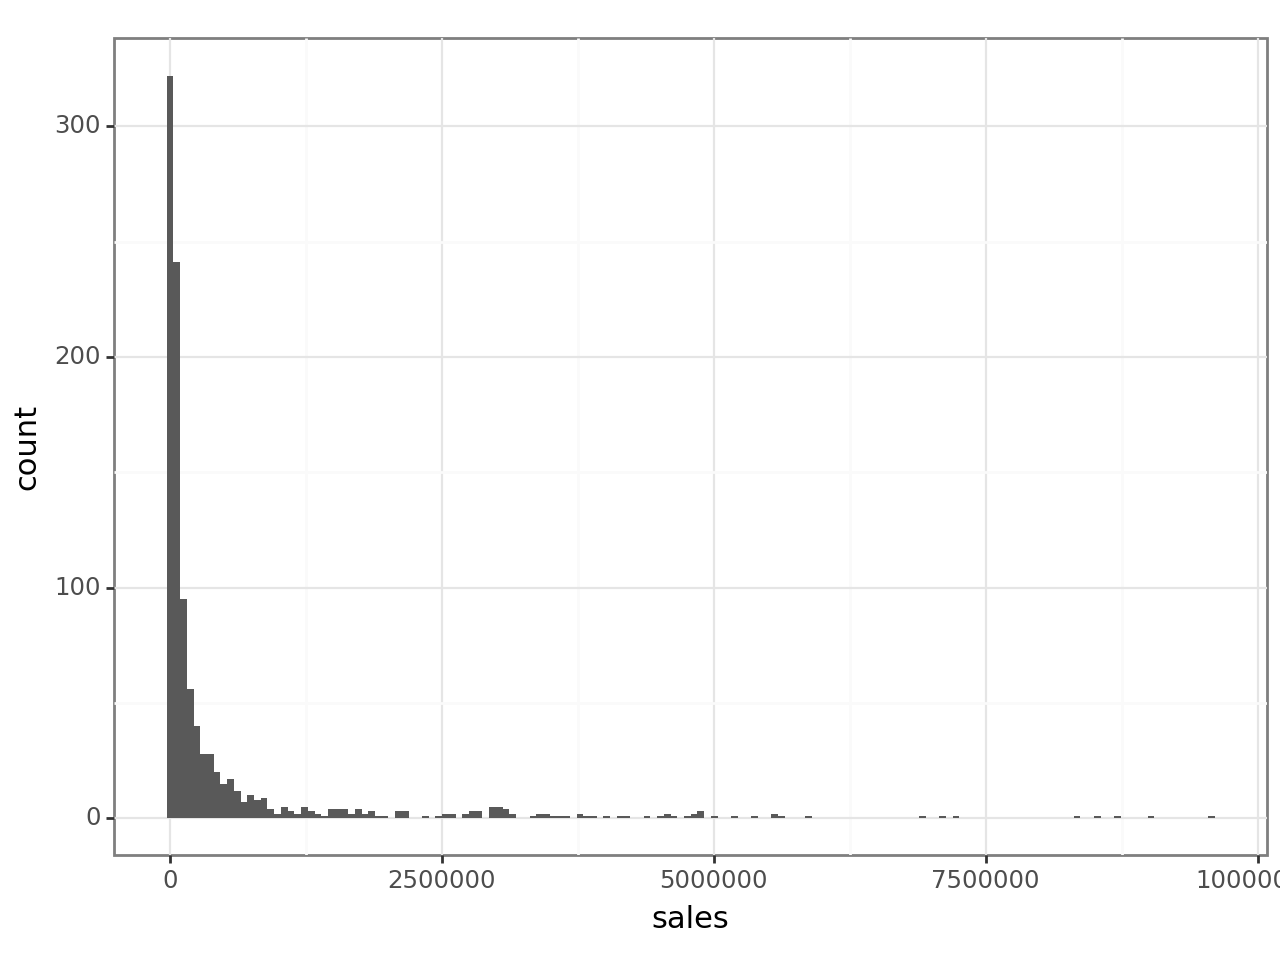

<Figure Size: (640 x 480)>

In [24]:
ggplot(holdout_data, aes("sales")) + geom_histogram() + theme_bw()

Most companies' sales are below 1M EUR in the holdout data.

In [25]:
holdout_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1037 entries, 417864 to 464055
Data columns (total 63 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   year                  1037 non-null   int64   
 1   comp_id               1037 non-null   float64 
 2   begin                 1037 non-null   object  
 3   end                   1037 non-null   object  
 4   amort                 1035 non-null   float64 
 5   curr_assets           1037 non-null   float64 
 6   curr_liab             1037 non-null   float64 
 7   extra_exp             1037 non-null   float64 
 8   extra_inc             1037 non-null   float64 
 9   extra_profit_loss     1037 non-null   float64 
 10  fixed_assets          1037 non-null   float64 
 11  inc_bef_tax           1037 non-null   float64 
 12  intang_assets         1037 non-null   float64 
 13  inventories           1037 non-null   float64 
 14  liq_assets            1037 non-null   float64 
 15  ma

The different training datasets will be taken from the `raw_data` DataFrame based on some criteria. 

In [26]:
# data1 will be the same industry with the same sales figure restrictions, just one year before - this will be a relatively small dataset.

data1 = raw_data.query("year==2013 & status_alive == 1")
data1 = data1.query("sales<=10000000 & sales>=1000 & ind2 == 26")
data1.shape

(1050, 63)

In [27]:
data1.default.value_counts()

default
0    999
1     51
Name: count, dtype: int64

In [28]:
round(data1.sales.describe(), 3)

count       1050.000
mean      465587.543
std      1173668.081
min         1000.000
25%        21786.112
50%        70418.516
75%       283219.438
max      9811389.000
Name: sales, dtype: float64

This dataset has very similar number of defaults as our holdout dataset, although its mean sales are a bit lower. It is likely to be quite similar to it in other features too, althoug it is quite a small dataset (only 1050 observations).

In [29]:
# data2 will include all industries (except the target) with the same sales figure restrictions, from the same year as our holdout data.

data2 = raw_data.query("year==2014 & status_alive == 1")
data2 = data2.query("sales<=10000000 & sales>=1000 & ind2 != 26")
data2.shape

(20253, 63)

In [30]:
data2.default.value_counts()

default
0    18177
1     2076
Name: count, dtype: int64

The default rate is higher than in the holdout set (around 10% vs 5%) but it is a much bigger sample.

In [31]:
round(data2.sales.describe(), 3)

count      20253.000
mean      255986.021
std       806844.236
min         1000.000
25%        17407.408
50%        50481.480
75%       157407.406
max      9963926.000
Name: sales, dtype: float64

Average sales are significantly lower than in the holdout set (256k vs 490k).

In [32]:
# data3 will include the same industry but one year earlier and with an even narrower sales filter - 
# given that most of the companies in the holdout data have less than 1M EUR sales, this filter will be applied here.

data3 = raw_data.query("year==2013 & status_alive == 1")
data3 = data3.query("sales<=1000000 & sales>=1000 & ind2 == 26")
data3.shape

(936, 63)

In [33]:
round(data3.sales.describe(), 3)

count       936.000
mean     138134.962
std      196431.376
min        1000.000
25%       18987.037
50%       51279.631
75%      165606.488
max      986803.688
Name: sales, dtype: float64

In [34]:
data3.default.value_counts()

default
0    887
1     49
Name: count, dtype: int64

In [35]:
to_filter=data1.isna().sum()
to_filter[to_filter>0]

amort                2
material_exp         2
personnel_exp        2
founded_year        92
ceo_count           92
foreign             92
female              92
inoffice_days       92
gender              92
origin              92
region_m             2
age                 92
material_exp_pl      2
personnel_exp_pl     2
dtype: int64

In [36]:
to_filter=data2.isna().sum()
to_filter[to_filter>0]

amort                    29
curr_assets              12
curr_liab                12
fixed_assets             12
intang_assets            12
inventories              12
liq_assets               12
material_exp             29
personnel_exp            29
profit_loss_year         12
share_eq                 12
subscribed_cap           12
tang_assets              12
founded_year           1056
ceo_count              1055
foreign                1055
female                 1055
inoffice_days          1055
gender                 1055
origin                 1055
nace_main                 5
ind2                      5
ind                     637
region_m                 58
founded_date              1
age                    1056
flag_asset_problem       12
total_assets_bs          12
inventories_pl           12
material_exp_pl          29
profit_loss_year_pl      12
personnel_exp_pl         29
dtype: int64

In [37]:
to_filter=data3.isna().sum()
to_filter[to_filter>0]

amort                1
material_exp         1
personnel_exp        1
founded_year        86
ceo_count           86
foreign             86
female              86
inoffice_days       86
gender              86
origin              86
age                 86
material_exp_pl      1
personnel_exp_pl     1
dtype: int64

Missing values will be dropped in data1-2-3. This will decrease the size of the datasets, but will retain only "clean" observations.
To retain the full 1037 observations in the holdout data, there all missing values will be imputed (with mean for numerical, and mode for categorical variables). Flags are to be added for all imputations.

In [38]:
to_filter=data1.isna().sum()
to_filter[to_filter>0]
data1.dropna(subset=to_filter[to_filter>0].index, inplace = True)

In [39]:
to_filter=data2.isna().sum()
to_filter[to_filter>0]
data2.dropna(subset=to_filter[to_filter>0].index, inplace = True)

In [40]:
to_filter=data3.isna().sum()
to_filter[to_filter>0]
data3.dropna(subset=to_filter[to_filter>0].index, inplace = True)

In [41]:
to_filter=holdout_data.isna().sum()
to_filter[to_filter>0]

amort                2
material_exp         2
personnel_exp        2
founded_year        31
ceo_count           31
foreign             31
female              31
inoffice_days       31
gender              31
origin              31
region_m             2
age                 31
material_exp_pl      2
personnel_exp_pl     2
dtype: int64

In [42]:
# Let's check how much the sales and default figures have changed due to dropping the NA values

round(data1.sales.describe(), 3)

count        955.000
mean      461643.749
std      1146901.911
min         1000.000
25%        21851.852
50%        72066.664
75%       289164.828
max      9811389.000
Name: sales, dtype: float64

In [43]:
round(data2.sales.describe(), 3)

count      18508.000
mean      254143.352
std       793106.390
min         1000.000
25%        17877.777
50%        51572.223
75%       159723.145
max      9963926.000
Name: sales, dtype: float64

In [44]:
round(data3.sales.describe(), 3)

count       849.000
mean     138906.431
std      196094.571
min        1000.000
25%       18988.889
50%       51481.480
75%      167270.375
max      986803.688
Name: sales, dtype: float64

In [45]:
data1.default.value_counts()

default
0    909
1     46
Name: count, dtype: int64

In [46]:
data2.default.value_counts()

default
0    16659
1     1849
Name: count, dtype: int64

In [47]:
data3.default.value_counts()

default
0    805
1     44
Name: count, dtype: int64

No major change to sales and default ratios.

# defining functions to impute

def impute_num(data, column):
    data[column +"_mod"] = np.where (
        data[column].isna(), data[column].mean(), data[column]
    )
    data["flag_"+ column] = (data[column].isna()).astype(int)
    data = data.drop([column], axis = 1, inplace = True)

def impute_cat(data, column):
    data[column +"_mod"] = np.where (
        data[column].isna(), data[column].mode(), data[column]
    )
    data["flag_"+ column] = (data[column].isna()).astype(int)
    data = data.drop([column], axis = 1, inplace = True)    
    
    
impute_num_list = ["amort", "material_exp", "personnel_exp", "founded_year", "ceo_count", "foreign", "female", "inoffice_days", "age"]
impute_cat_list = ["gender", "origin", "region_m"]

In [48]:
# defining functions to impute

def impute_num(data, column):
    data["flag_"+ column] = (data[column].isna()).astype(int)
    data[column] = np.where (
        data[column].isna(), data[column].mean(), data[column]
    )
    

def impute_cat(data, column):
    data["flag_"+ column] = (data[column].isna()).astype(int)  
    data[column] = np.where (
        data[column].isna(), data[column].mode(), data[column]
    )
    
impute_num_list = ["amort", "material_exp", "personnel_exp", "founded_year", "ceo_count", "foreign", "female", "inoffice_days", "age"]
impute_cat_list = ["gender", "origin", "region_m"]

In [49]:
for col in impute_num_list:
    impute_num(holdout_data, col)

for col in impute_cat_list:
    impute_cat(holdout_data, col)
    
to_filter=holdout_data.isna().sum()
to_filter[to_filter>0]

material_exp_pl     2
personnel_exp_pl    2
dtype: int64

In [50]:
holdout_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1037 entries, 417864 to 464055
Data columns (total 75 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   year                  1037 non-null   int64   
 1   comp_id               1037 non-null   float64 
 2   begin                 1037 non-null   object  
 3   end                   1037 non-null   object  
 4   amort                 1037 non-null   float64 
 5   curr_assets           1037 non-null   float64 
 6   curr_liab             1037 non-null   float64 
 7   extra_exp             1037 non-null   float64 
 8   extra_inc             1037 non-null   float64 
 9   extra_profit_loss     1037 non-null   float64 
 10  fixed_assets          1037 non-null   float64 
 11  inc_bef_tax           1037 non-null   float64 
 12  intang_assets         1037 non-null   float64 
 13  inventories           1037 non-null   float64 
 14  liq_assets            1037 non-null   float64 
 15  ma

In [51]:
# recalculate missing values for _pl variables, and rename columns
pl_names2 = ["material_exp", "personnel_exp"]
holdout_data[[col + "_pl" for col in pl_names2]] = holdout_data[pl_names2].div(
    holdout_data["sales"], axis="index")

In [52]:
holdout_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1037 entries, 417864 to 464055
Data columns (total 75 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   year                  1037 non-null   int64   
 1   comp_id               1037 non-null   float64 
 2   begin                 1037 non-null   object  
 3   end                   1037 non-null   object  
 4   amort                 1037 non-null   float64 
 5   curr_assets           1037 non-null   float64 
 6   curr_liab             1037 non-null   float64 
 7   extra_exp             1037 non-null   float64 
 8   extra_inc             1037 non-null   float64 
 9   extra_profit_loss     1037 non-null   float64 
 10  fixed_assets          1037 non-null   float64 
 11  inc_bef_tax           1037 non-null   float64 
 12  intang_assets         1037 non-null   float64 
 13  inventories           1037 non-null   float64 
 14  liq_assets            1037 non-null   float64 
 15  ma

In [53]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 955 entries, 371478 to 417643
Data columns (total 63 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   year                  955 non-null    int64   
 1   comp_id               955 non-null    float64 
 2   begin                 955 non-null    object  
 3   end                   955 non-null    object  
 4   amort                 955 non-null    float64 
 5   curr_assets           955 non-null    float64 
 6   curr_liab             955 non-null    float64 
 7   extra_exp             955 non-null    float64 
 8   extra_inc             955 non-null    float64 
 9   extra_profit_loss     955 non-null    float64 
 10  fixed_assets          955 non-null    float64 
 11  inc_bef_tax           955 non-null    float64 
 12  intang_assets         955 non-null    float64 
 13  inventories           955 non-null    float64 
 14  liq_assets            955 non-null    float64 
 15  mat

# Modeling
## Defining variable sets

There are number of feature sets that we can define: raw company-related features, P&L (as % of sales) and BS related (as % of total assets) and HR-related. Plus the categorical features.

In [94]:
raw_vars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp", 
            "profit_loss_year", "sales", "share_eq", "subscribed_cap", "age", "balsheet_flag", "balsheet_length", "balsheet_notfullyear", "flag_asset_problem"]

fin_vars = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]

hr_vars = ["female", "ceo_count", "foreign", "inoffice_days", "labor_avg_mod",
        "flag_miss_labor_avg", "birth_year_mod", "flag_miss_birth_year"]

cat_vars = ["gender", "origin", "ind2", "ind", "urban_m", "region_m"]

In [60]:
# despite data1 and data3 not containing different ind2 values, this matrix will be created as this is a relevan variable for data2.

data1.ind2.value_counts()

ind2
26.0    955
1.0       0
69.0      0
74.0      0
73.0      0
       ... 
45.0      0
46.0      0
47.0      0
49.0      0
96.0      0
Name: count, Length: 68, dtype: int64

In [73]:
ind2_catmat = patsy.dmatrix("0 + C(ind2)",data1, return_type="dataframe")
ind2_catmat = ind2_catmat.drop(['C(ind2)[1.0]'], axis=1)

In [78]:
ind_catmat = patsy.dmatrix("0 + C(ind)",data1, return_type="dataframe")
ind_catmat = ind_catmat.drop(['C(ind)[1.0]'], axis=1)

In [71]:
m_region_locmat = patsy.dmatrix("0 + C(region_m)",data1, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(region_m)[Central]'], axis=1)

In [70]:
urban_mmat = patsy.dmatrix("0 + C(urban_m)",data1, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1.0]'], axis=1)

In [79]:
data1.gender

371478    female
371577       mix
371582      male
371697    female
371709       mix
           ...  
417463      male
417553      male
417606      male
417620      male
417643      male
Name: gender, Length: 955, dtype: category
Categories (3, object): ['female', 'male', 'mix']

In [80]:
gender_catmat = patsy.dmatrix("0 + C(gender)",data1, return_type="dataframe")
gender_catmat = gender_catmat.drop(['C(gender)[male]'], axis=1)

In [81]:
data1.origin

371478    Domestic
371577    Domestic
371582    Domestic
371697    Domestic
371709    Domestic
            ...   
417463    Domestic
417553    Domestic
417606    Domestic
417620         mix
417643    Domestic
Name: origin, Length: 955, dtype: category
Categories (3, object): ['Domestic', 'Foreign', 'mix']

In [82]:
origin_catmat = patsy.dmatrix("0 + C(origin)",data1, return_type="dataframe")
origin_catmat = origin_catmat.drop(['C(origin)[Domestic]'], axis=1)

#### Modeling on data1

3 logistics regression models are to be created: one with only the raw and financial variables, another with categorical variables added, and a third with all HR variables added. 5-fold cross validation is to be applied. On top, a random forest model is to be created as well.

In [88]:
raw = data1[raw_vars]
fin = data1[fin_vars]
X1 = pd.concat([raw, fin], axis=1)

In [89]:
X2 = pd.concat([X1, ind2_catmat, ind_catmat, m_region_locmat, urban_mmat, gender_catmat, origin_catmat], axis=1)

In [116]:
hr = data1[hr_vars]
X3 = pd.concat([X1, X2, hr], axis = 1)

In [117]:
rfvars  = pd.concat([X1, X2, hr], axis=1)

In [118]:
y = data1['default']

Note: no training-holdout split needed, as the holdout data is already defined. The whole data1 is to be used for training.

In [119]:
# specifying cross-validation 
k = KFold(n_splits = 5, shuffle = True, random_state = 20240224)

In [120]:
# no regularisation needed so setting the paremeter to very high value
Cs_value_logit = [1e20]

In [121]:
logit_model_vars = [X1, X2, X3]

logit_models = dict()
CV_RMSE_folds = dict()

In [122]:
%%time
for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(
        Cs=Cs_value_logit, 
        cv=k,
        refit=True, 
        scoring='neg_brier_score', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state=20240224)
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y)
    
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-1*(logit_models['X'+str(i+1)].scores_[1])).flatten()

CPU times: total: 1.88 s
Wall time: 2.05 s


In [124]:
pd.DataFrame(CV_RMSE_folds)

,X1,X2,X3
0,0.218916,0.217157,0.226883
1,0.251325,0.251325,0.203268
2,0.228273,0.229075,0.236496
3,0.244914,0.244559,0.254733
4,0.276164,0.276164,0.256437


In [125]:
# checking AUC scores as well
CV_AUC_folds = dict()

for i in range(len(logit_model_vars)):
    LRCV_auc = LogisticRegressionCV(
        Cs=Cs_value_logit, 
        cv=k, 
        refit=True, 
        scoring='roc_auc', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state = 20240205)
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y)
    # Calculate AUC on test for each fold
    CV_AUC_folds['X'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

In [126]:
pd.DataFrame(CV_AUC_folds)

,X1,X2,X3
0,0.722727,0.744444,0.717677
1,0.482883,0.482883,0.572072
2,0.584860,0.600122,0.723443
3,0.642929,0.636869,0.758081
4,0.661783,0.661783,0.623932


In [127]:
CV_RMSE = dict()
CV_AUC = dict()

for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])  

logit_summary1 = np.transpose(pd.DataFrame.from_dict([CV_RMSE,CV_AUC], orient='columns'))
logit_summary1.columns = ['CV RMSE', 'CV AUC']

In [128]:
logit_summary1

,CV RMSE,CV AUC
X1,0.243918,0.619036
X2,0.243656,0.625220
X3,0.235563,0.679041


In data1, both with RMSE and AUC the best performing model is X3 - which is the most complex one. 

#### Random forest

In [129]:
grid = {'max_features': [5, 6, 7],
        'criterion':['gini'],
        'min_samples_split': [11, 16]}

In [132]:
prob_forest = RandomForestClassifier(
    random_state=20240224, 
    n_estimators=500, 
    oob_score=True)

prob_forest_grid = GridSearchCV(
    prob_forest, 
    grid, 
    cv=k, 
    refit='accuracy',
    scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], 
    n_jobs=-1)

In [133]:
%%time
prob_forest_fit = prob_forest_grid.fit(rfvars, y)

CPU times: total: 1.7 s
Wall time: 8.52 s


In [144]:
# checking out accuracy, RMSE and AUC

cv_accuracy = np.zeros([6])
for i in range(5):
    cv_accuracy = cv_accuracy + prob_forest_fit.cv_results_['split' + str(i) + '_test_accuracy']
cv_accuracy = cv_accuracy/5
cv_accuracy

array([0.95183246, 0.95183246, 0.95183246, 0.95183246, 0.95183246,
       0.95183246])

In [135]:
cv_auc = np.zeros([6])
for i in range(5):
    cv_auc = cv_auc + prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc = cv_auc/5
cv_auc

array([0.72894808, 0.72596425, 0.71653413, 0.72592441, 0.70928774,
       0.71843793])

In [136]:
cv_rmse = np.zeros([6])
for i in range(5):
    cv_rmse = cv_rmse +np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse = cv_rmse/5
cv_rmse

array([0.20908651, 0.20893397, 0.20943068, 0.20902761, 0.20988963,
       0.2096005 ])

In [137]:
prob_forest_cv_results = pd.DataFrame({
    'max_features': prob_forest_fit.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit.cv_results_['param_min_samples_split'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})

In [138]:
prob_forest_cv_results

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,5,11,0.951832,0.728948,0.209087
1,5,16,0.951832,0.725964,0.208934
2,6,11,0.951832,0.716534,0.209431
3,6,16,0.951832,0.725924,0.209028
4,7,11,0.951832,0.709288,0.209890
5,7,16,0.951832,0.718438,0.209601


In [143]:
best_max_features = prob_forest_fit.best_params_['max_features']
best_min_sample_split = prob_forest_fit.best_params_['min_samples_split']

In [142]:
print(f'The best random forest model has the following features: {prob_forest_fit.best_params_}')

The best random forest model has the following features: {'criterion': 'gini', 'max_features': 5, 'min_samples_split': 11}


The random forest model produced much better results than the best performing X3 logistics regression.